In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
# %matplotlib notebook 

In [2]:
import yaml
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers as tfl
from tensorflow_addons.image import transform as H_transform
import os
from models.utils import box_nms
import cv2
import matplotlib.pyplot as plt
import numpy as np
from models.homographies import *
from utils.tools import dict_update
from plot_utils import plot_imgs

from models.utils import shared_encoder, detector_head, detector_loss, model_metrics, box_nms

In [3]:
import yaml
with open('/root/Internship-Valeo/Project/configs/magic-point_kitti360_export.yaml', 'r') as stream:
    config = yaml.safe_load(stream)

In [4]:
default_config = {
        'labels': None,
        'cache_in_memory': False,
        'validation_size': 100,
        'truncate': None,
        'preprocessing': {
            'resize': [160, 480]
        },
        'num_parallel_calls': 10,
        'augmentation': {
            'photometric': {
                'enable': False,
                'primitives': 'all',
                'params': {},
                'random_order': True,
            },
            'homographic': {
                'enable': False,
                'params': {},
                'valid_border_margin': 0,
            },
        },
        'warped_pair': {
            'enable': False,
            'params': {},
            'valid_border_margin': 0,
        },
    }

config1 = config
config = dict_update(default_config, config['data'])

In [5]:
default_model_config = {
            'data_format': 'channels_last',
            'kernel_reg': 0.,
            'grid_size': 8,
            'detection_threshold': 0.4,
            'homography_adaptation': {'num': 0},
            'nms': 0,
            'top_k': 0
    }

In [6]:
model_config = dict_update(default_model_config, config1['model'])

In [7]:
class DetectorLossLayer(Layer):
    def __init__(self, name='detector_loss_layer', trainable=False):
        super(DetectorLossLayer, self).__init__(name=name)
        self.loss_fn = detector_loss
        self.metrics_fn = model_metrics
    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(inputs[0], inputs[1]['logits'], model_config = model_config, valid_mask = inputs[2])
        
        if model_config['nms']:
            prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), inputs[1]['prob'])
        pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
        
        metrics = self.metrics_fn(inputs[0], pred, valid_mask = inputs[2])
#         self.add_loss(tf.math.reduce_mean(loss))
        self.add_loss(loss)
        self.add_metric(metrics['precision'], name = 'precision')
        self.add_metric(metrics['recall'], name = 'recall')
        return loss
    def compute_output_shape(self, input_shape):
        return [1]

def net(input_shape1, input_shape2, input_shape3):
    images_inputs = Input(shape = input_shape1, name = 'image')
    valid_masks_inputs = Input(shape = input_shape2, name = 'valid_mask')
    warped_points_inputs = Input(shape = input_shape3, name = 'keypoints')
    
    encoder = shared_encoder(shape = (None, None, 1), model_config = model_config)
    encoder_output = encoder(images_inputs)
    
    detector = detector_head(shape= (None, None, 128), model_config = model_config)
    output = detector(encoder_output)
        
    loss_layer = DetectorLossLayer()([warped_points_inputs, output, valid_masks_inputs])
    
    model = keras.models.Model(inputs = [images_inputs, valid_masks_inputs, warped_points_inputs] , 
                               outputs = [loss_layer])
    return model

In [8]:
model = net(input_shape1 = (None, None, 1), input_shape2 = (None, None), input_shape3 = (None, None))

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [25]:
# model.load_weights(filepath='/root/Internship-Valeo/Project/results/checkpoint-magicpoint-80x240-synth-aug-060723')
model.load_weights(filepath='/root/Internship-Valeo/Project/results/checkpoint-magicpoint-kitti360-100723')

In [26]:
K = np.array([[707.0912, 0, 601.8873],
              [0, 707.0912, 183.1104],
              [0, 0, 1]])

In [27]:
!pwd

/root/Internship-Valeo/Project


In [28]:
image_0_path_list = glob.glob('/root/Internship-Valeo/Project/data/kitti/data_odometry_color/dataset/sequences/07/image_2/*')
image_0_path_list.sort()
print(image_0_path_list[1001])

/root/Internship-Valeo/Project/data/kitti/data_odometry_color/dataset/sequences/07/image_2/001001.png


In [29]:
depth_path_list = glob.glob('/root/Internship-Valeo/Project/data/kitti/packnet-depth/07/*.npz')
depth_path_list.sort()
print(depth_path_list[1001])

/root/Internship-Valeo/Project/data/kitti/packnet-depth/07/001001.npz


In [30]:
def is_seq(data):
    """Checks if data is a list or tuple."""
    return isinstance(data, tuple) or isinstance(data, list)

def inv2depth(inv_depth):
    """
    Invert an inverse depth map to produce a depth map

    Parameters
    ----------
    inv_depth : torch.Tensor or list of torch.Tensor [B,1,H,W]
        Inverse depth map

    Returns
    -------
    depth : torch.Tensor or list of torch.Tensor [B,1,H,W]
        Depth map
    """
    if is_seq(inv_depth):
        return [inv2depth(item) for item in inv_depth]
    else:
        return 1./np.clip(inv_depth, 1e-6,None)
#         return 1. / inv_depth.clamp(min=1e-6)

In [31]:
img0 = cv2.imread(image_0_path_list[0], cv2.IMREAD_UNCHANGED)
h, w, c = img0.shape
img0_list = []
depth_list = []
inv_depth_list = []
for i in range(len(image_0_path_list)):
    img = cv2.imread(image_0_path_list[i], cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img0_list.append(img)
    inv_depth = np.load(depth_path_list[i])['depth']
    depth = inv2depth(inv_depth)
    depth = cv2.resize(depth, dsize = (w, h), interpolation=cv2.INTER_CUBIC)
    inv_depth = cv2.resize(inv_depth, dsize = (w, h), interpolation=cv2.INTER_CUBIC)
    depth_list.append(depth)
    inv_depth_list.append(inv_depth)

In [32]:
inv_depth_list[0]

array([[ 8.240717 , 10.239111 , 10.527029 , ..., 15.054845 , 14.384303 ,
         8.161318 ],
       [ 9.847582 , 10.282145 , 10.5716   , ..., 14.767749 , 14.408398 ,
        12.818278 ],
       [10.141199 , 10.455187 , 10.562993 , ..., 14.839075 , 14.670847 ,
        13.9909725],
       ...,
       [ 6.050388 ,  6.061881 ,  6.110701 , ...,  5.805771 ,  5.792425 ,
         5.7516174],
       [ 6.038504 ,  6.015505 ,  6.054997 , ...,  5.7440605,  5.774204 ,
         5.678001 ],
       [ 4.8795795,  6.0069776,  6.0479555, ...,  5.7253103,  5.686593 ,
         5.2411137]], dtype=float32)

In [33]:
ground_data = np.loadtxt('/root/Internship-Valeo/Project/data/kitti/poses/07.txt')

In [34]:
ground_data[0]

array([1.000000e+00, 1.197625e-11, 1.704638e-10, 5.551115e-17,
       1.197625e-11, 1.000000e+00, 3.562503e-10, 0.000000e+00,
       1.704638e-10, 3.562503e-10, 1.000000e+00, 2.220446e-16])

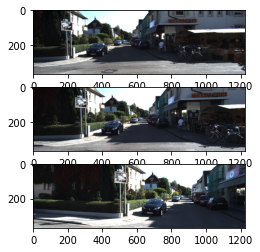

In [35]:
fig, axis = plt.subplots(3,1)
axis[0].imshow(img0_list[0])
axis[1].imshow(img0_list[10])
axis[2].imshow(img0_list[20])
plt.show()

# Using SIFT 

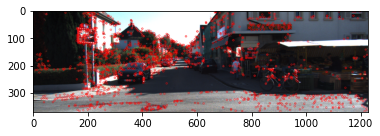

In [36]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
keypoints1, descriptors1 = sift.detectAndCompute(img0_list[0], None)

output_image = cv2.drawKeypoints(img0_list[0], keypoints1, 0, (255, 0, 0))
plt.imshow(output_image)
plt.show()

# Inference on SuperPoint

In [37]:
img = cv2.cvtColor(img0_list[0], cv2.COLOR_RGB2GRAY)
img = cv2.resize(img, (480,160))
img = img.reshape(1,img.shape[0], img.shape[1],1)

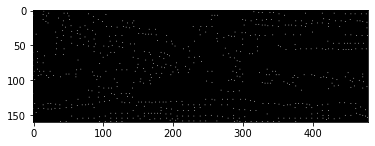

In [38]:
output = model.get_layer('detector_loss_layer').input[1]
m = keras.models.Model(inputs = model.input[0], outputs = output)

y_pred = m.predict(img)

if model_config['nms']:
    prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), y_pred['prob'])
    pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
    
# pred = pred * tf.cast(x['valid_mask'], tf.float32) # multiplied with valid masks

plt.imshow(pred[0], cmap = 'gray')

In [39]:
def keypoints_from_response_map(response_map, threshold=0):
    """
    Converts a 2D array of response values to a list of OpenCV keypoints.

    :param response_map: 2D array where each element represents a response value
    :param threshold: Minimum response value to consider for a keypoint
    :return: List of OpenCV KeyPoints
    """
    keypoints = []
    
    # Iterate over the 2D array
    for y in range(response_map.shape[0]):  # height (rows)
        for x in range(response_map.shape[1]):  # width (columns)
            response = response_map[y, x]
            if response > threshold:
                # Create a keypoint at (x, y) with the size and response
                kp = cv2.KeyPoint(x=x, y=y, size=1, response=response)
                keypoints.append(kp)
    
    return keypoints

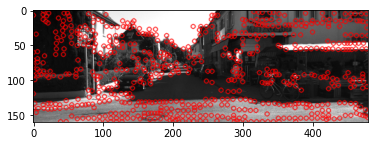

In [40]:
kp = keypoints_from_response_map(np.array(prob[0]))
output_image = cv2.drawKeypoints(img[0], kp, 0, (255, 0, 0))
plt.imshow(output_image)
plt.show()

In [12]:
kp1 = []
for point in keypoints1:
    kp1.append(point.pt)
np.asarray(kp1)

array([[   9.01809025,  217.40550232],
       [  15.40552616,  160.60641479],
       [  15.47348118,  182.50114441],
       ...,
       [1219.06091309,  356.18652344],
       [1220.54724121,  362.30834961],
       [1221.48779297,  162.07145691]])

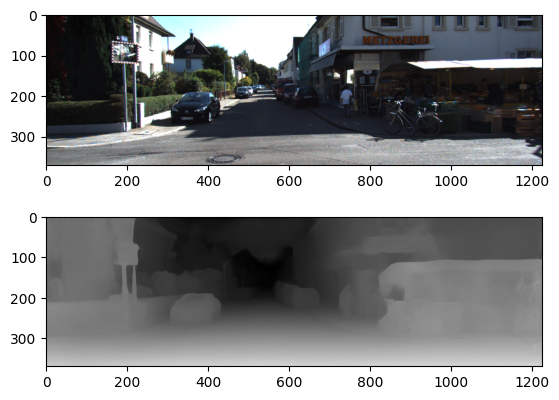

In [13]:
# image = image.permute((0,2,3,1))
fig, axis = plt.subplots(2,1)
# axis[0].imshow(image[0])
axis[0].imshow(img0_list[0])
axis[1].imshow(depth_list[0],'gray')
plt.show()

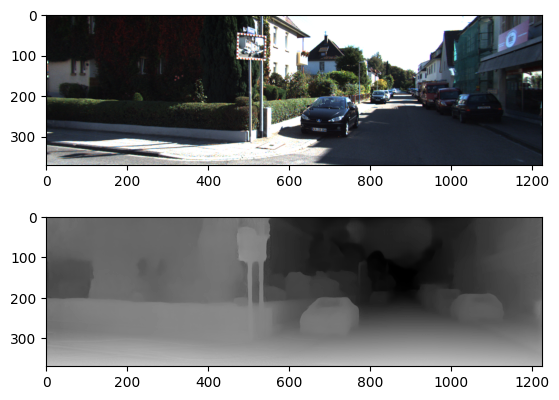

In [14]:
# image1 = image1.permute((0,2,3,1))
fig, axis = plt.subplots(2,1)
# axis[0].imshow(image1[0])
axis[0].imshow(img0_list[20])
axis[1].imshow(depth_list[20],'gray')
plt.show()

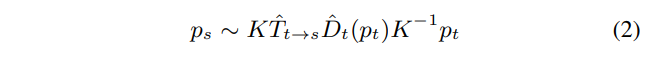

In [15]:
np.array(kp1, 'int')[789] # SIFT keypoints are floats converted to integers

array([354, 304])

In [16]:
len(kp1)

2022

In [17]:
point = np.ones((3,1),'int')
point[0,0] = np.array(kp1,'int')[789][1]
point[1,0] = np.array(kp1,'int')[789][0]

In [18]:
point[1,0]

354

In [19]:
def pixel2cam(depth, pixel_coords, intrinsics, is_homogeneous=True):
    """Transforms coordinates in the pixel frame to the camera frame.
    
    Args:
    depth: [batch, height, width]
    pixel_coords: homogeneous pixel coordinates [batch, 3, height, width]
    intrinsics: camera intrinsics [batch, 3, 3]
    is_homogeneous: return in homogeneous coordinates
    Returns:
    Coords in the camera frame [batch, 3 (4 if homogeneous), height, width]
    """
    batch, height, width = depth.shape
    depth = np.reshape(depth, [batch, 1, -1])
    pixel_coords = np.reshape(pixel_coords, [batch, 3, -1])
    cam_coords = np.matmul(np.linalg.inv(intrinsics), pixel_coords) * depth
    if is_homogeneous:
        ones = np.ones([batch, 1, height*width])
        cam_coords = np.concatenate([cam_coords, ones], axis=1)
        cam_coords = np.reshape(cam_coords, [batch, -1, height, width])
    return cam_coords

In [20]:
def cam2pixel(cam_coords, proj):
    """Transforms coordinates in a camera frame to the pixel frame.

    Args:
      cam_coords: [batch, 4, height, width]
      proj: [batch, 4, 4]
    Returns:
      Pixel coordinates projected from the camera frame [batch, height, width, 2]
    """
    batch, _, height, width = cam_coords.shape
    cam_coords = cam_coords.reshape(batch, 4, -1)
    # Perform matrix multiplication
    unnormalized_pixel_coords = np.matmul(proj, cam_coords)
    
    # Extract x, y, z coordinates
    x_u = unnormalized_pixel_coords[:, 0:1, :]
    y_u = unnormalized_pixel_coords[:, 1:2, :]
    z_u = unnormalized_pixel_coords[:, 2:3, :]
    
    # Normalize x and y coordinates by z
    x_n = x_u / (z_u + 1e-10)
    y_n = y_u / (z_u + 1e-10)
    # Concatenate x and y coordinates
    pixel_coords = np.concatenate([x_n, y_n], axis=1)
    # Reshape and transpose to get the final pixel coordinates
    pixel_coords = pixel_coords.reshape(batch, 2, height, width)
    return np.transpose(pixel_coords, (0, 2, 3, 1))

In [21]:
def meshgrid(batch, height, width, is_homogeneous=True):
    """Construct a 2D meshgrid.

    Args:
      batch: batch size
      height: height of the grid
      width: width of the grid
      is_homogeneous: whether to return in homogeneous coordinates
    Returns:
      x,y grid coordinates [batch, 2 (3 if homogeneous), height, width]
    """
    # Create 1D arrays of coordinates
    x = np.linspace(-1.0, 1.0, width)
    y = np.linspace(-1.0, 1.0, height)

    # Create 2D grids of coordinates
    x_t, y_t = np.meshgrid(x, y)

    # Rescale coordinates to [0, width-1] and [0, height-1]
    x_t = (x_t + 1.0) * 0.5 * (width - 1)
    y_t = (y_t + 1.0) * 0.5 * (height - 1)

    if is_homogeneous:
        ones = np.ones_like(x_t)
        coords = np.stack([x_t, y_t, ones], axis=0)
    else:
        coords = np.stack([x_t, y_t], axis=0)

    # Tile coordinates for batch size
    coords = np.tile(coords[np.newaxis, ...], (batch, 1, 1, 1))
    
    return coords

In [22]:
def bilinear_sampler(imgs, coords):
    """Construct a new image by bilinear sampling from the input image.

    Points falling outside the source image boundary have value 0.

    Args:
      imgs: source image to be sampled from [batch, height_s, width_s, channels]
      coords: coordinates of source pixels to sample from [batch, height_t, width_t, 2]. 
              height_t/width_t correspond to the dimensions of the output image 
              (don't need to be the same as height_s/width_s). 
              The two channels correspond to x and y coordinates respectively.
    Returns:
      A new sampled image [batch, height_t, width_t, channels]
    """
    
    batch, height_s, width_s, channels = imgs.shape
    _, height_t, width_t, _ = coords.shape
    
    coords_x, coords_y = coords[..., 0], coords[..., 1]

    # Clip coordinates to be within image boundaries
    x0 = np.floor(coords_x).astype(np.int32)
    x1 = x0 + 1
    y0 = np.floor(coords_y).astype(np.int32)
    y1 = y0 + 1

    x0 = np.clip(x0, 0, width_s - 1)
    x1 = np.clip(x1, 0, width_s - 1)
    y0 = np.clip(y0, 0, height_s - 1)
    y1 = np.clip(y1, 0, height_s - 1)

    # Get pixel values at corner points
    Ia = imgs[np.arange(batch)[:, None, None], y0, x0]
    Ib = imgs[np.arange(batch)[:, None, None], y1, x0]
    Ic = imgs[np.arange(batch)[:, None, None], y0, x1]
    Id = imgs[np.arange(batch)[:, None, None], y1, x1]

    # Calculate interpolation weights
    wa = (x1 - coords_x) * (y1 - coords_y)
    wb = (x1 - coords_x) * (coords_y - y0)
    wc = (coords_x - x0) * (y1 - coords_y)
    wd = (coords_x - x0) * (coords_y - y0)

    # Compute the output
    output = wa[..., None] * Ia + wb[..., None] * Ib + wc[..., None] * Ic + wd[..., None] * Id
    return output

In [23]:
def projective_inverse_warp(img, depth, pose, intrinsics):
    
    """Inverse warp a source image to the target image plane based on projection.

    Args:
      img: the source image [batch, height_s, width_s, 3]
      depth: depth map of the target image [batch, height_t, width_t]
      pose: target to source camera transformation matrix [batch, 4, 4]
      intrinsics: camera intrinsics [batch, 3, 3]
    Returns:
      Source image inverse warped to the target image plane [batch, height_t,
      width_t, 3]
    """
    batch, height, width, _ = img.shape
    # Construct pixel grid coordinates
    pixel_coords = meshgrid(batch, height, width)
    # Convert pixel coordinates to the camera frame
    cam_coords = pixel2cam(depth, pixel_coords, intrinsics)
    # Construct a 4x4 intrinsic matrix (TODO: can it be 3x4?)    
    filler = np.array([0.0, 0.0, 0.0, 1.0], dtype=np.float32).reshape(1, 1, 4)
    filler = np.tile(filler, (batch, 1, 1))
    intrinsics = np.concatenate([intrinsics, np.zeros((batch, 3, 1), dtype=np.float32)], axis=2)
    intrinsics = np.concatenate([intrinsics, filler], axis=1)
    # Get a 4x4 transformation matrix from 'target' camera frame to 'source'
    # pixel frame.
    proj_tgt_cam_to_src_pixel = np.matmul(intrinsics, pose)
    src_pixel_coords = cam2pixel(cam_coords, proj_tgt_cam_to_src_pixel)
    output_img = bilinear_sampler(img, src_pixel_coords)
    return output_img

In [24]:
# import math
# def get6DoFPose(p):
#     pos = np.array([p[3], p[7], p[11]])
#     R = np.array([[p[0], p[1], p[2]], [p[4], p[5], p[6]], [p[8], p[9], p[10]]])
#     angles = rotationMatrixToEulerAngles(R)
#     return np.concatenate((pos, angles))

# def isRotationMatrix(R):
#     Rt = np.transpose(R)
#     shouldBeIdentity = np.dot(Rt, R)
#     I = np.identity(3, dtype=R.dtype)
#     n = np.linalg.norm(I - shouldBeIdentity)
#     return n < 1e-6

# def rotationMatrixToEulerAngles(R):
#     assert (isRotationMatrix(R))
#     sy = math.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])
#     singular = sy < 1e-6

#     if not singular:
#         x = math.atan2(R[2, 1], R[2, 2])
#         y = math.atan2(-R[2, 0], sy)
#         z = math.atan2(R[1, 0], R[0, 0])
#     else:
#         x = math.atan2(-R[1, 2], R[1, 1])
#         y = math.atan2(-R[2, 0], sy)
#         z = 0
#     return np.array([x, y, z], dtype=np.float32)
# def eulerAnglesToRotationMatrix(theta) :
#     R_x = np.array([[1,         0,                  0                   ],
#                     [0,         math.cos(theta[0]), -math.sin(theta[0]) ],
#                     [0,         math.sin(theta[0]), math.cos(theta[0])  ]
#                     ])           
#     R_y = np.array([[math.cos(theta[1]),    0,      math.sin(theta[1])  ],
#                     [0,                     1,      0                   ],
#                     [-math.sin(theta[1]),   0,      math.cos(theta[1])  ]
#                     ])        
#     R_z = np.array([[math.cos(theta[2]),    -math.sin(theta[2]),    0],
#                     [math.sin(theta[2]),    math.cos(theta[2]),     0],
#                     [0,                     0,                      1]
#                     ])               
#     R = np.dot(R_z, np.dot( R_y, R_x ))
#     return R
# def getHomogeneous(p):
#     pos = np.array([p[0], p[1], p[2]])
#     theta = np.array([p[3], p[4], p[5]])
#     R = eulerAnglesToRotationMatrix(theta)
# #     R = R.flatten()
# #     mat = np.array([R[0], R[1], R[2],pos[0],R[3], R[4], R[5],pos[1], 
# #                     R[6], R[7], R[8],pos[2], 0, 0 ,0, 1]).reshape(4,4)
#     mat = np.concatenate((R, pos.reshape(3,1)), axis = 1)
#     mat = np.concatenate((mat.flatten(), np.asarray([0,0,0,1]))).reshape(4,4)
#     return mat

In [25]:
ground_data_0 = np.concatenate((ground_data[0],np.asarray([0,0,0,1]))).reshape(4,4)
ground_data_0

array([[1.000000e+00, 1.197625e-11, 1.704638e-10, 5.551115e-17],
       [1.197625e-11, 1.000000e+00, 3.562503e-10, 0.000000e+00],
       [1.704638e-10, 3.562503e-10, 1.000000e+00, 2.220446e-16],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00]])

In [26]:
ground_data_20 = np.concatenate((ground_data[20],np.asarray([0,0,0,1]))).reshape(4,4)
ground_data_20

array([[ 0.8999654 ,  0.02432815, -0.4352819 , -1.103633  ],
       [-0.02866013,  0.9995834 , -0.00338884, -0.04676236],
       [ 0.4350182 ,  0.01552507,  0.9002878 ,  3.142085  ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [27]:
# pose: target to source camera transformation matrix
# Transformation of frame 20 relative to frame 0.
# frame0_frame20 = frame0_ref * ref_frame20 = (ref_frame0)^(-1) * ref_frame20
relative_pose = np.linalg.inv(ground_data_0).dot(ground_data_20)
np.expand_dims(relative_pose,0)

array([[[ 0.8999654 ,  0.02432815, -0.4352819 , -1.103633  ],
        [-0.02866013,  0.9995834 , -0.00338884, -0.04676236],
        [ 0.4350182 ,  0.01552507,  0.9002878 ,  3.142085  ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]])

In [28]:
# src_img: img0_list[0]
# target_img: img0_list[20]
src_img = np.expand_dims(img0_list[0],0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


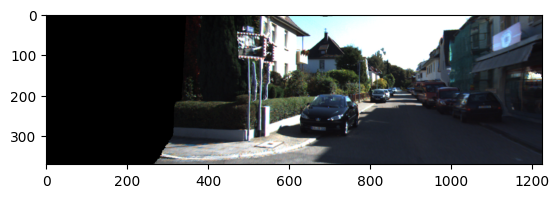

In [29]:
output = projective_inverse_warp(src_img, np.expand_dims(inv_depth_list[20],0), 
                                 np.expand_dims(relative_pose,0), np.expand_dims(K,0))
plt.imshow(output[0]/255.)

In [30]:
# overlay = np.zeros((output[0].shape[0], output[0].shape[1], 3))
# overlay.shape
# # overlay[:output[0].shape[0],:] = cv2.cvtColor((output[0]).astype(np.uint8), cv2.COLOR_RGB2GRAY)
# # overlay[output[0].shape[0]:,:] = cv2.cvtColor(img0_list[20], cv2.COLOR_RGB2GRAY)
# overlay[:,:,0] = cv2.cvtColor((output[0]).astype(np.uint8), cv2.COLOR_RGB2GRAY)/255.
# overlay[:,:,1] = cv2.cvtColor(img0_list[20], cv2.COLOR_RGB2GRAY)/255.
# plt.imshow(overlay)

In [31]:
# # fc = cv2.VideoWriter_fourcc('F','M','P','4')
# # video = cv2.VideoWriter('1.mp4', fc, 1, (h, w))
# kp_list = {}
# kp_list['image'] = []
# kp_list['kp_map'] = []
# n = 3 # number of frames to use
# f_diff = 1 # frame difference
# # for index in range(len(img0_list)-f_diff):
# for index in range(100):
#     target_index = (f_diff*(n-1)//2)+index
# #     print('target_index:',target_index)
#     kp_list['image'].append(img0_list[target_index])
#     target_inv_depth = inv_depth_list[target_index]
#     ground_data_target = np.concatenate((ground_data[target_index],np.asarray([0,0,0,1]))).reshape(4,4)
#     j = 0
#     src_index = index+j*f_diff
# #     print('src_index:', src_index)
#     src_img = np.expand_dims(img0_list[src_index],0)
#     target_image = img0_list[target_index]
#     ground_data_src = np.concatenate((ground_data[src_index],np.asarray([0,0,0,1]))).reshape(4,4)
#     relative_pose = np.linalg.inv(ground_data_src).dot(ground_data_target)
#     output = projective_inverse_warp(src_img, np.expand_dims(target_inv_depth,0), 
#                                  np.expand_dims(relative_pose,0), np.expand_dims(K,0))
    
#     overlay = np.zeros((output[0].shape[0]*2, output[0].shape[1]))
#     overlay[:output[0].shape[0],:] = cv2.cvtColor((output[0]).astype(np.uint8), cv2.COLOR_RGB2GRAY)
#     overlay[output[0].shape[0]:output[0].shape[0]*2,:] = cv2.cvtColor(target_image, cv2.COLOR_RGB2GRAY)
# #     overlay = np.zeros((output[0].shape[0], output[0].shape[1], 3))
# #     overlay[:,:,0] = cv2.cvtColor((output[0]).astype(np.uint8), cv2.COLOR_RGB2GRAY)
# #     overlay[:,:,1] = cv2.cvtColor(target_image, cv2.COLOR_RGB2GRAY)
#     cv2.imwrite('/spslam/temp/'+str(index)+'.jpg', overlay)
# #     video.write(overlay)
# #     video.release()

In [32]:
n = 51 # number of frames to use
f_diff = 1 # frame difference

kp_list = {}
kp_list['target_image'] = []
kp_list['target_depth'] = []
for index in range(len(img0_list)-n):
    # getting the middle/target frame/target depth
    kp_list['target_image'].append(img0_list[(f_diff*(n-1)//2)+index])
    target_inv_depth = inv_depth_list[(f_diff*(n-1)//2)+index]
    kp_list['target_depth'].append(target_inv_depth)
    ground_data_target = np.concatenate((ground_data[(f_diff*(n-1)//2)+index],
                                         np.asarray([0,0,0,1]))).reshape(4,4)
    for j in range(n):
        kp_list['src_image'] = []
        kp_list['view_synthesis'] = []
        if j != (n-1)//2:
            src_img = img0_list[index+j*f_diff]
            kp_list['src_image'].append(src_img)
            ground_data_src = np.concatenate((ground_data[index+j*f_diff],
                                              np.asarray([0,0,0,1]))).reshape(4,4)
            relative_pose = np.linalg.inv(ground_data_src).dot(ground_data_target)
            output = projective_inverse_warp(np.expand_dims(src_img,0),
                                             np.expand_dims(target_inv_depth,0), 
                                 np.expand_dims(relative_pose,0), np.expand_dims(K,0)) 
            kp_list['view_synthesis'].append(output[0])
#     break

IndexError: list index out of range

In [ ]:
# fig, axis = plt.subplots(n, 2, figsize=(12, n*2), dpi= 100, facecolor='w', edgecolor='k')
# # fig, axis = plt.subplots(n,2)

# for i in range(n):
#     if i == (n-1)/2:
#         axis[i,0].imshow(kp_list['target_image'][0])
#         axis[i,1].imshow(kp_list['target_depth'][0],'gray')  
#     elif i < (n-1)/2:
#         axis[i,0].imshow(kp_list['src_image'][i])
#         axis[i,1].imshow(kp_list['view_synthesis'][i]/255.)
#     else:
#         axis[i,0].imshow(kp_list['src_image'][i-1]) 
#         axis[i,1].imshow(kp_list['view_synthesis'][i-1]/255.)
# plt.show()

In [34]:
def bilinear_interpolation_keypoints_map(keypoints, map_width, map_height):
    """
    Create a 2D keypoint map from a list of OpenCV keypoints using bilinear interpolation.

    :param keypoints: List of cv2.KeyPoint objects
    :param map_width: Width of the keypoints map
    :param map_height: Height of the keypoints map
    :return: 2D keypoints map
    """
    # Create an empty keypoints map (2D array)
    keypoint_map = np.zeros((map_height, map_width), dtype=np.float32)
    
    # Iterate over each keypoint
    for kp in keypoints:
        # Extract keypoint coordinates and response
        x, y = kp.pt
        response = kp.response

        # Get the surrounding grid points
        x0, y0 = int(np.floor(x)), int(np.floor(y))
        x1, y1 = x0 + 1, y0 + 1

        # Compute distances to the surrounding points
        dx = x - x0
        dy = y - y0

        # Compute the interpolation weights
        w00 = (1 - dx) * (1 - dy)
        w01 = (1 - dx) * dy
        w10 = dx * (1 - dy)
        w11 = dx * dy

        # Distribute the keypoint response to the 4 neighboring points
        if 0 <= x0 < map_width and 0 <= y0 < map_height:
            keypoint_map[y0, x0] += response * w00
        if 0 <= x0 < map_width and 0 <= y1 < map_height:
            keypoint_map[y1, x0] += response * w01
        if 0 <= x1 < map_width and 0 <= y0 < map_height:
            keypoint_map[y0, x1] += response * w10
        if 0 <= x1 < map_width and 0 <= y1 < map_height:
            keypoint_map[y1, x1] += response * w11
    return keypoint_map

In [88]:
n = 51 # number of frames to use
f_diff = 1 # frame difference

kp_list['target_image'] = []
kp_list['label'] = []
kp_list['target_depth'] = []
# Initialize SIFT detector
sift = cv2.SIFT_create()

for index in range(len(img0_list)-n+1):
    target_index = (f_diff*(n-1)//2)+index
    kp_list['target_image'].append(img0_list[target_index])
    target_inv_depth = inv_depth_list[target_index]
    kp_list['target_depth'].append(target_inv_depth)
    ground_data_target = np.concatenate((ground_data[target_index],
                                         np.asarray([0,0,0,1]))).reshape(4,4)
    kp_list['kp_map'] = []
    for j in range(n):
        kp_list['src_image'] = []
        kp_list['src_kp'] = []
        
        kp_list['kp_synthesis'] = []
        if j != (n-1)//2:
            src_index = index+j*f_diff
            src_img = np.expand_dims(img0_list[src_index],0)
            kp_list['src_image'].append(src_img)
            # Detect keypoints and descriptors
            keypoints1, descriptors1 = sift.detectAndCompute(src_img[0], None)
            kp_list['src_kp'].append(keypoints1)
            ground_data_src = np.concatenate((ground_data[src_index],
                                              np.asarray([0,0,0,1]))).reshape(4,4)
            relative_pose = np.linalg.inv(ground_data_src).dot(ground_data_target)
            kp_map = bilinear_interpolation_keypoints_map(keypoints1, w, h)
#             kp1 = []
#             kp_map = np.zeros((h,w))
#             for point in keypoints1:
#                 kp1.append(point.pt)
#                 kp_map[int(point.pt[1]), int(point.pt[0])] = point.response
            kp_map = np.expand_dims(kp_map, 0)
            kp_map = np.expand_dims(kp_map, 3)
            
            output = projective_inverse_warp(kp_map, np.expand_dims(target_inv_depth,0), 
                                 np.expand_dims(relative_pose,0), np.expand_dims(K,0))
            output = output.reshape(1,output.shape[1],-1)
#             kp_list['kp_synthesis'].append(keypoints_from_response_map(output[0]))
            kp_list['kp_map'].append(output)
    kp_list['label'].append(sum(kp_list['kp_map'])/np.max(sum(kp_list['kp_map'])))
#     break       

In [ ]:
# fig, axis = plt.subplots(n, 2, figsize=(12, n*2), dpi= 100, facecolor='w', edgecolor='k')
# for i in range(n):
#     if i == (n-1)/2:
#         axis[i,0].imshow(kp_list['target_image'][0])
#         axis[i,1].imshow(kp_list['target_depth'][0],'gray')  
#     elif i < (n-1)/2:
#         src_image = cv2.drawKeypoints(kp_list['src_image'][i][0], kp_list['src_kp'][i], 
#                                  0, (255, 0, 0))
#         axis[i,0].imshow(src_image)
#         output_image = cv2.drawKeypoints(np.uint8(kp_list['view_synthesis'][i]), kp_list['kp_synthesis'][i], 
#                                  0, (255, 0, 0))
#         axis[i,1].imshow(output_image)
#     else:
#         src_image = cv2.drawKeypoints(kp_list['src_image'][i-1][0], kp_list['src_kp'][i-1], 
#                                  0, (255, 0, 0))
#         axis[i,0].imshow(src_image) 
#         output_image = cv2.drawKeypoints(np.uint8(kp_list['view_synthesis'][i-1]), kp_list['kp_synthesis'][i-1], 
#                                  0, (255, 0, 0))
#         axis[i,1].imshow(output_image)
# plt.show()

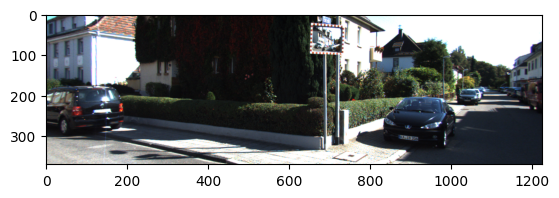

In [89]:
plt.imshow(kp_list['target_image'][0])

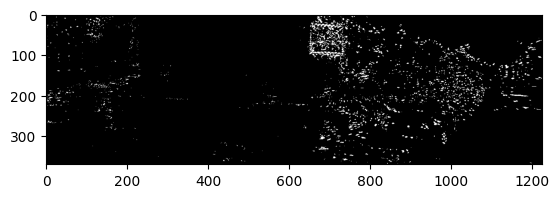

In [90]:
plt.imshow(kp_list['label'][0][0]>0.05, 'gray')

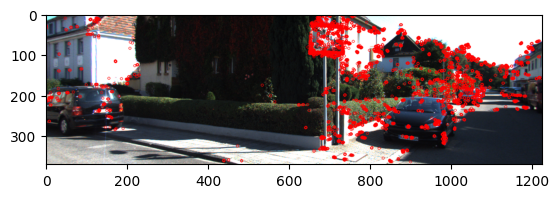

In [97]:
img = cv2.drawKeypoints(kp_list['target_image'][0], keypoints_from_response_map((kp_list['label'][0][0]>0.1).astype('float')), 
                               0, (255, 0, 0))
plt.imshow(img)

In [106]:
np.nonzero(kp_list['label'][0][0]>0.1)[0].shape

(4234,)

In [99]:
kp_list.keys()

dict_keys(['target_image', 'target_depth', 'src_image', 'view_synthesis', 'label', 'src_kp', 'kp_map', 'kp_synthesis'])

In [100]:
kp_list['label'][0].shape

(1, 370, 1226)

In [101]:
len(kp_list['label'])

1051

In [102]:
len(kp_list['target_image'])

1051

In [103]:
kp_list['target_image'][0].shape

(370, 1226, 3)

In [104]:
kp_list['label'][0][0].shape

(370, 1226)

In [105]:
keypoints_from_response_map(kp_list['label'][0][0])

[< cv2.KeyPoint 0x7f581c74c510>,
 < cv2.KeyPoint 0x7f581c74d140>,
 < cv2.KeyPoint 0x7f581c74cf30>,
 < cv2.KeyPoint 0x7f581c8663d0>,
 < cv2.KeyPoint 0x7f581c866430>,
 < cv2.KeyPoint 0x7f581c8664c0>,
 < cv2.KeyPoint 0x7f581c970e70>,
 < cv2.KeyPoint 0x7f581c727c90>,
 < cv2.KeyPoint 0x7f581c8cea60>,
 < cv2.KeyPoint 0x7f581c8ceac0>,
 < cv2.KeyPoint 0x7f581c9fe2e0>,
 < cv2.KeyPoint 0x7f581c74d170>,
 < cv2.KeyPoint 0x7f581c74c930>,
 < cv2.KeyPoint 0x7f581c74cff0>,
 < cv2.KeyPoint 0x7f581c74c270>,
 < cv2.KeyPoint 0x7f581c74cd50>,
 < cv2.KeyPoint 0x7f581c74c120>,
 < cv2.KeyPoint 0x7f581c74d0b0>,
 < cv2.KeyPoint 0x7f581c74c4b0>,
 < cv2.KeyPoint 0x7f581c74c0c0>,
 < cv2.KeyPoint 0x7f581c74c570>,
 < cv2.KeyPoint 0x7f581c74d080>,
 < cv2.KeyPoint 0x7f581c74c600>,
 < cv2.KeyPoint 0x7f581c74c060>,
 < cv2.KeyPoint 0x7f581c74c150>,
 < cv2.KeyPoint 0x7f581c74cf00>,
 < cv2.KeyPoint 0x7f581c74d1d0>,
 < cv2.KeyPoint 0x7f581c74d200>,
 < cv2.KeyPoint 0x7f581c74d230>,
 < cv2.KeyPoint 0x7f581c74d260>,
 < cv2.Key